In [1]:
import sqlite3
import pandas as pd
import re


In [26]:
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.util import ngrams

In [4]:
conn = sqlite3.connect("challenge_gold.db")
print ("Opened database successfully")

Opened database successfully


In [5]:
sosmed = pd.read_sql_query('SELECT * FROM data_sosmed', conn)
sosmed.head(10)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,cleaned_text
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0,disaat semua cowok berusaha melacak perhatian ...
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0,rt user user siapa yang telat ngasih tau elued...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0,41 kadang aku berfikir kenapa aku tetap percay...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0,user user aku itu akunnku tau matamu sipit tap...
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0,user user kaum cebong kapir udah keliatan dong...
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x...,1,1,0,1,0,0,0,0,1,0,1,0,user ya bani taplak dkk xf0x9fx98x84xf0x9fx98x...
6,deklarasi pilkada 2018 aman dan anti hoax warg...,0,0,0,0,0,0,0,0,0,0,0,0,deklarasi pilkada 2018 aman dan anti hoax warg...
7,Gue baru aja kelar re-watch Aldnoah Zero!!! pa...,0,1,0,0,0,0,0,0,0,0,0,0,gue baru aja kelar rewatch aldnoah zero paling...
8,Nah admin belanja satu lagi port terbaik nak m...,0,0,0,0,0,0,0,0,0,0,0,0,nah admin belanja satu lagi port terbaik nak m...
9,USER Enak lg klo smbil ngewe',0,1,0,0,0,0,0,0,0,0,0,0,user enak lg klo smbil ngewe


In [11]:
sosmed['cleaned_text'].head(50)

0     disaat semua cowok berusaha melacak perhatian ...
1     rt user user siapa yang telat ngasih tau elued...
2     41 kadang aku berfikir kenapa aku tetap percay...
3     user user aku itu akunnku tau matamu sipit tap...
4     user user kaum cebong kapir udah keliatan dong...
5     user ya bani taplak dkk xf0x9fx98x84xf0x9fx98x...
6     deklarasi pilkada 2018 aman dan anti hoax warg...
7     gue baru aja kelar rewatch aldnoah zero paling...
8     nah admin belanja satu lagi port terbaik nak m...
9                          user enak lg klo smbil ngewe
10    setidaknya gw punya jari tengah buat lu sebelo...
11    user user user user banci kaleng malu ga bisa ...
12    kalo belajar ekonomi mestinya jago memprivatis...
13    aktor huruhara 98 prabowo s ingin lengserkan p...
14    user bu guru enakan jadi jablay atau guru esde...
15    user user user user user user lawan bicara gw ...
16           belakangan ini kok fikiran ampas banget ya
17    ari sarua beki mah repeh monyetxf0x9fx98x8

In [14]:
# Check duplicate
sosmed.duplicated().sum()

0

In [13]:
# Remove duplicate
sosmed = sosmed.drop_duplicates()

In [15]:
# Check missing value
sosmed.isnull().sum()

Tweet            0
HS               0
Abusive          0
HS_Individual    0
HS_Group         0
HS_Religion      0
HS_Race          0
HS_Physical      0
HS_Gender        0
HS_Other         0
HS_Weak          0
HS_Moderate      0
HS_Strong        0
cleaned_text     0
dtype: int64

### EDA - Normalisasi Penulisan

In [16]:
kamusalay = pd.read_csv('new_kamusalay.csv', encoding='latin1', names=['singkatan', 'normal'])
kamusalay_dict = dict(zip(kamusalay['singkatan'], kamusalay['normal']))
kamusalay_dict

{'anakjakartaasikasik': 'anak jakarta asyik asyik',
 'pakcikdahtua': 'pak cik sudah tua',
 'pakcikmudalagi': 'pak cik muda lagi',
 't3tapjokowi': 'tetap jokowi',
 '3x': 'tiga kali',
 'aamiin': 'amin',
 'aamiinn': 'amin',
 'aamin': 'amin',
 'aammiin': 'amin',
 'abis': 'habis',
 'abisin': 'habiskan',
 'acau': 'kacau',
 'achok': 'ahok',
 'ad': 'ada',
 'adek': 'adik',
 'adl': 'adalah',
 'adlah': 'adalah',
 'adlh': 'adalah',
 'ado': 'ada',
 'aduhh': 'aduh',
 'aer': 'air',
 'afdol': 'afdal',
 'agamaataualqur': 'agama alquran',
 'agm': 'agama',
 'agma': 'agama',
 'ahaha': 'haha',
 'ahahaha': 'haha',
 'ahehehehe': 'hehe',
 'ahir': 'akhir',
 'ahirnya': 'akhirnya',
 'ahk': 'ahok',
 'ahlamdulillah': 'alhamdulillah',
 'ahli2': 'para ahli',
 'ahlusunnah': 'ahlus sunah',
 'ahmaddani': 'ahmad dhani',
 'aho': 'ahok',
 'ahoax': 'ahok',
 'ahoaxx': 'ahok',
 'ahog': 'ahok',
 'ahokataudjarot': 'ahok djarot',
 'ahokbebanijokowi': 'ahok beban jokowi',
 'ahokbtp': 'ahok basuki tjahaja purnama',
 'ahokditolakw

In [17]:
def normalize_text(text):
    words = text.split()
    normalized_words = [kamusalay_dict[word] if word in kamusalay_dict else word for word in words]
    return ' '.join(normalized_words)

sosmed['normalized_text'] = sosmed['cleaned_text'].apply(normalize_text)

print(sosmed[['cleaned_text', 'normalized_text']].head(20))

                                         cleaned_text  \
0   disaat semua cowok berusaha melacak perhatian ...   
1   rt user user siapa yang telat ngasih tau elued...   
2   41 kadang aku berfikir kenapa aku tetap percay...   
3   user user aku itu akunnku tau matamu sipit tap...   
4   user user kaum cebong kapir udah keliatan dong...   
5   user ya bani taplak dkk xf0x9fx98x84xf0x9fx98x...   
6   deklarasi pilkada 2018 aman dan anti hoax warg...   
7   gue baru aja kelar rewatch aldnoah zero paling...   
8   nah admin belanja satu lagi port terbaik nak m...   
9                        user enak lg klo smbil ngewe   
10  setidaknya gw punya jari tengah buat lu sebelo...   
11  user user user user banci kaleng malu ga bisa ...   
12  kalo belajar ekonomi mestinya jago memprivatis...   
13  aktor huruhara 98 prabowo s ingin lengserkan p...   
14  user bu guru enakan jadi jablay atau guru esde...   
15  user user user user user user lawan bicara gw ...   
16         belakangan ini kok f

### Analisis Panjang Teks

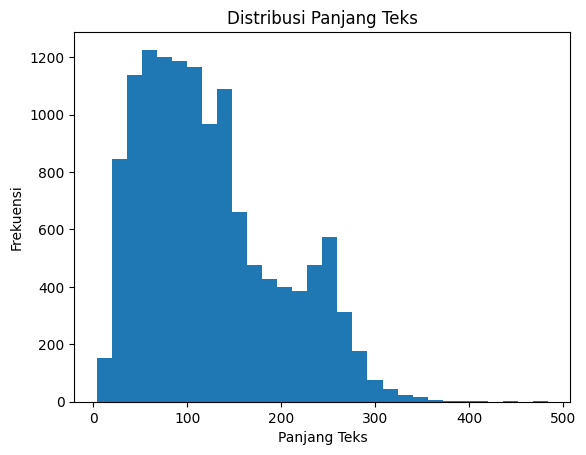

In [23]:
sosmed['text_length'] = sosmed['normalized_text'].apply(len)

import matplotlib.pyplot as plt
plt.hist(sosmed['text_length'], bins=30)
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.title('Distribusi Panjang Teks')
plt.show()


### Menghilangkan Stopwords

In [27]:
pip install nltk


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [29]:
from nltk.tokenize import word_tokenize

def word_tokenize_wrapper(text):
    return word_tokenize(text)

sosmed['teks_token'] = sosmed['normalized_text'].apply(word_tokenize_wrapper)
sosmed

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,cleaned_text,normalized_text,text_length,unique_words,teks_token
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0,disaat semua cowok berusaha melacak perhatian ...,di saat semua cowok berusaha melacak perhatian...,133,17,"[di, saat, semua, cowok, berusaha, melacak, pe..."
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0,rt user user siapa yang telat ngasih tau elued...,rt pengguna pengguna siapa yang telat memberi ...,126,19,"[rt, pengguna, pengguna, siapa, yang, telat, m..."
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0,41 kadang aku berfikir kenapa aku tetap percay...,41 kadang aku berpikir kenapa aku tetap percay...,250,29,"[41, kadang, aku, berpikir, kenapa, aku, tetap..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0,user user aku itu akunnku tau matamu sipit tap...,pengguna pengguna aku itu akunnku tau matamu s...,81,11,"[pengguna, pengguna, aku, itu, akunnku, tau, m..."
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0,user user kaum cebong kapir udah keliatan dong...,pengguna pengguna kaum cebong kafir sudah keli...,94,13,"[pengguna, pengguna, kaum, cebong, kafir, suda..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,1,1,1,0,0,0,1,0,0,1,0,0,user jangan asal ngomong ndasmu congor lu yg s...,pengguna jangan asal berbicara ndasmu congor k...,73,11,"[pengguna, jangan, asal, berbicara, ndasmu, co..."
13165,USER Kasur mana enak kunyuk',0,1,0,0,0,0,0,0,0,0,0,0,user kasur mana enak kunyuk,pengguna kasur mana enak kunyuk,31,5,"[pengguna, kasur, mana, enak, kunyuk]"
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,0,0,0,0,0,0,0,0,0,0,0,0,user hati hati bisu gnnlagi bosan huft xf0x9fx...,pengguna hati hati bisu gnnlagi bosan duh xf0x...,54,7,"[pengguna, hati, hati, bisu, gnnlagi, bosan, d..."
13167,USER USER USER USER Bom yang real mudah terdet...,0,0,0,0,0,0,0,0,0,0,0,0,user user user user bom yang real mudah terdet...,pengguna pengguna pengguna pengguna bom yang r...,150,17,"[pengguna, pengguna, pengguna, pengguna, bom, ..."


In [66]:
from nltk.corpus import stopwords

list_stopwords = stopwords.words('indonesian')

list_stopwords.extend(["pengguna", "rt", "ya", "sih", "nya", 'kayak',
                       'ganti', 'banget', 'nih', 'uniform', 'resource', 
                       'locator', 'tau', 'wkwk', 'amp', 'iya', 'pakai', 
                       'orang', 'gue', 'suka', 'haha'])

list_stopwords = set(list_stopwords)

def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

sosmed["remove_stopwords"]= sosmed['teks_token'].apply(stopwords_removal)

sosmed["remove_stopwords"]=sosmed["remove_stopwords"].str.join(sep=" ")

sosmed

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,...,HS_Strong,cleaned_text,normalized_text,text_length,unique_words,teks_token,remove_stopwords,teks_token2,sentiment,contains_abusive
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,...,0,disaat semua cowok berusaha melacak perhatian ...,di saat semua cowok berusaha melacak perhatian...,133,17,"[di, saat, semua, cowok, berusaha, melacak, pe...",cowok berusaha melacak perhatian lantas remehk...,"[cowok, berusaha, melacak, perhatian, lantas, ...",Netral,True
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,...,0,rt user user siapa yang telat ngasih tau elued...,rt pengguna pengguna siapa yang telat memberi ...,126,19,"[rt, pengguna, pengguna, siapa, yang, telat, m...",telat eluedan sarap bergaul cigax jifla calis ...,"[telat, eluedan, sarap, bergaul, cigax, jifla,...",Netral,True
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,...,0,41 kadang aku berfikir kenapa aku tetap percay...,41 kadang aku berpikir kenapa aku tetap percay...,250,29,"[41, kadang, aku, berpikir, kenapa, aku, tetap...",41 kadang berpikir percaya tuhan jatuh berkali...,"[41, kadang, berpikir, percaya, tuhan, jatuh, ...",Netral,False
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,...,0,user user aku itu akunnku tau matamu sipit tap...,pengguna pengguna aku itu akunnku tau matamu s...,81,11,"[pengguna, pengguna, aku, itu, akunnku, tau, m...",akunnku matamu sipit,"[akunnku, matamu, sipit]",Netral,True
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,...,0,user user kaum cebong kapir udah keliatan dong...,pengguna pengguna kaum cebong kafir sudah keli...,94,13,"[pengguna, pengguna, kaum, cebong, kafir, suda...",kaum cebong kafir dongoknya dungu,"[kaum, cebong, kafir, dongoknya, dungu, haha]",Positif,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,1,1,1,0,0,0,1,0,0,...,0,user jangan asal ngomong ndasmu congor lu yg s...,pengguna jangan asal berbicara ndasmu congor k...,73,11,"[pengguna, jangan, asal, berbicara, ndasmu, co...",berbicara ndasmu congor sekata anjing,"[berbicara, ndasmu, congor, sekata, anjing]",Netral,True
13165,USER Kasur mana enak kunyuk',0,1,0,0,0,0,0,0,0,...,0,user kasur mana enak kunyuk,pengguna kasur mana enak kunyuk,31,5,"[pengguna, kasur, mana, enak, kunyuk]",kasur enak kunyuk,"[kasur, enak, kunyuk]",Netral,True
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,0,0,0,0,0,0,0,0,0,...,0,user hati hati bisu gnnlagi bosan huft xf0x9fx...,pengguna hati hati bisu gnnlagi bosan duh xf0x...,54,7,"[pengguna, hati, hati, bisu, gnnlagi, bosan, d...",hati hati bisu gnnlagi bosan duh xf0x9fx98xaa,"[hati, hati, bisu, gnnlagi, bosan, duh, xf0x9f...",Negatif,True
13167,USER USER USER USER Bom yang real mudah terdet...,0,0,0,0,0,0,0,0,0,...,0,user user user user bom yang real mudah terdet...,pengguna pengguna pengguna pengguna bom yang r...,150,17,"[pengguna, pengguna, pengguna, pengguna, bom, ...",bom real mudah terdeteksi bom terkubur dahsyat...,"[bom, real, mudah, terdeteksi, bom, terkubur, ...",Positif,False


### EDA - Analisis Kata Unik

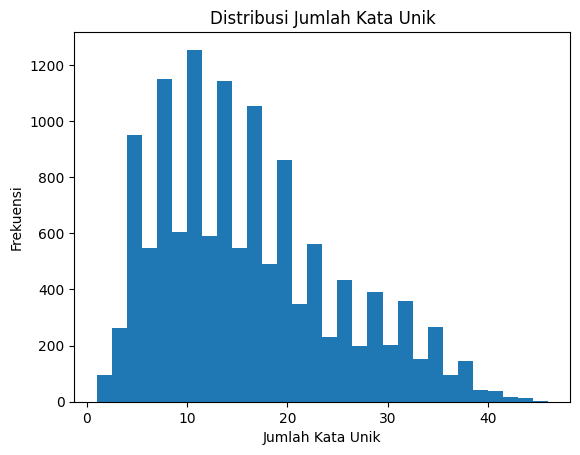

In [24]:
sosmed['unique_words'] = sosmed['normalized_text'].apply(lambda x: len(set(x.split())))

plt.hist(sosmed['unique_words'], bins=30)
plt.xlabel('Jumlah Kata Unik')
plt.ylabel('Frekuensi')
plt.title('Distribusi Jumlah Kata Unik')
plt.show()

### Analisis Frekuensi Kata

In [67]:
def word_tokenize_wrapper2(text):
    return word_tokenize(text)

sosmed['teks_token2'] = sosmed['remove_stopwords'].apply(word_tokenize_wrapper2)
sosmed

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,...,HS_Strong,cleaned_text,normalized_text,text_length,unique_words,teks_token,remove_stopwords,teks_token2,sentiment,contains_abusive
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,...,0,disaat semua cowok berusaha melacak perhatian ...,di saat semua cowok berusaha melacak perhatian...,133,17,"[di, saat, semua, cowok, berusaha, melacak, pe...",cowok berusaha melacak perhatian lantas remehk...,"[cowok, berusaha, melacak, perhatian, lantas, ...",Netral,True
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,...,0,rt user user siapa yang telat ngasih tau elued...,rt pengguna pengguna siapa yang telat memberi ...,126,19,"[rt, pengguna, pengguna, siapa, yang, telat, m...",telat eluedan sarap bergaul cigax jifla calis ...,"[telat, eluedan, sarap, bergaul, cigax, jifla,...",Netral,True
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,...,0,41 kadang aku berfikir kenapa aku tetap percay...,41 kadang aku berpikir kenapa aku tetap percay...,250,29,"[41, kadang, aku, berpikir, kenapa, aku, tetap...",41 kadang berpikir percaya tuhan jatuh berkali...,"[41, kadang, berpikir, percaya, tuhan, jatuh, ...",Netral,False
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,...,0,user user aku itu akunnku tau matamu sipit tap...,pengguna pengguna aku itu akunnku tau matamu s...,81,11,"[pengguna, pengguna, aku, itu, akunnku, tau, m...",akunnku matamu sipit,"[akunnku, matamu, sipit]",Netral,True
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,...,0,user user kaum cebong kapir udah keliatan dong...,pengguna pengguna kaum cebong kafir sudah keli...,94,13,"[pengguna, pengguna, kaum, cebong, kafir, suda...",kaum cebong kafir dongoknya dungu,"[kaum, cebong, kafir, dongoknya, dungu]",Positif,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,1,1,1,0,0,0,1,0,0,...,0,user jangan asal ngomong ndasmu congor lu yg s...,pengguna jangan asal berbicara ndasmu congor k...,73,11,"[pengguna, jangan, asal, berbicara, ndasmu, co...",berbicara ndasmu congor sekata anjing,"[berbicara, ndasmu, congor, sekata, anjing]",Netral,True
13165,USER Kasur mana enak kunyuk',0,1,0,0,0,0,0,0,0,...,0,user kasur mana enak kunyuk,pengguna kasur mana enak kunyuk,31,5,"[pengguna, kasur, mana, enak, kunyuk]",kasur enak kunyuk,"[kasur, enak, kunyuk]",Netral,True
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,0,0,0,0,0,0,0,0,0,...,0,user hati hati bisu gnnlagi bosan huft xf0x9fx...,pengguna hati hati bisu gnnlagi bosan duh xf0x...,54,7,"[pengguna, hati, hati, bisu, gnnlagi, bosan, d...",hati hati bisu gnnlagi bosan duh xf0x9fx98xaa,"[hati, hati, bisu, gnnlagi, bosan, duh, xf0x9f...",Negatif,True
13167,USER USER USER USER Bom yang real mudah terdet...,0,0,0,0,0,0,0,0,0,...,0,user user user user bom yang real mudah terdet...,pengguna pengguna pengguna pengguna bom yang r...,150,17,"[pengguna, pengguna, pengguna, pengguna, bom, ...",bom real mudah terdeteksi bom terkubur dahsyat...,"[bom, real, mudah, terdeteksi, bom, terkubur, ...",Positif,False


Kata-kata paling umum:
[('indonesia', 1572), ('presiden', 1429), ('jokowi', 1091), ('islam', 822), ('agama', 718), ('partai', 693), ('komunis', 677), ('asing', 664), ('rakyat', 629), ('cina', 581)]


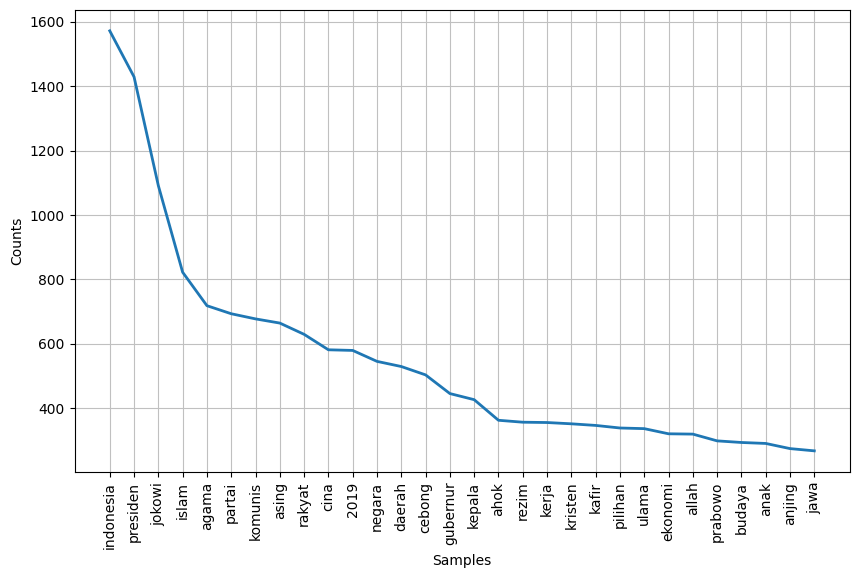

In [68]:
from nltk.probability import FreqDist

all_tokens = [token for sublist in sosmed['teks_token2'] for token in sublist]

freq_dist = FreqDist(all_tokens)

# Menampilkan 10 kata paling umum
print("Kata-kata paling umum:")
print(freq_dist.most_common(10))

plt.figure(figsize=(10, 6))
freq_dist.plot(30, cumulative=False)
plt.show()

### Analisis Sentimen

In [41]:
from textblob import TextBlob

def analyze_sentiment_textblob(text):
    analysis = TextBlob(text)
    # TextBlob memberikan nilai sentimen antara -1 dan 1
    if analysis.sentiment.polarity > 0:
        return 'Positif'
    elif analysis.sentiment.polarity == 0:
        return 'Netral'
    else:
        return 'Negatif'

sosmed['sentiment'] = sosmed['normalized_text'].apply(analyze_sentiment_textblob)

sosmed

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,...,HS_Moderate,HS_Strong,cleaned_text,normalized_text,text_length,unique_words,teks_token,remove_stopwords,teks_token2,sentiment
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,...,0,0,disaat semua cowok berusaha melacak perhatian ...,di saat semua cowok berusaha melacak perhatian...,133,17,"[di, saat, semua, cowok, berusaha, melacak, pe...",cowok berusaha melacak perhatian gue lantas re...,"[cowok, berusaha, melacak, perhatian, gue, lan...",Netral
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,...,0,0,rt user user siapa yang telat ngasih tau elued...,rt pengguna pengguna siapa yang telat memberi ...,126,19,"[rt, pengguna, pengguna, siapa, yang, telat, m...",rt pengguna pengguna telat tau eluedan sarap g...,"[rt, pengguna, pengguna, telat, tau, eluedan, ...",Netral
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,...,0,0,41 kadang aku berfikir kenapa aku tetap percay...,41 kadang aku berpikir kenapa aku tetap percay...,250,29,"[41, kadang, aku, berpikir, kenapa, aku, tetap...",41 kadang berpikir percaya tuhan jatuh berkali...,"[41, kadang, berpikir, percaya, tuhan, jatuh, ...",Netral
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,...,0,0,user user aku itu akunnku tau matamu sipit tap...,pengguna pengguna aku itu akunnku tau matamu s...,81,11,"[pengguna, pengguna, aku, itu, akunnku, tau, m...",pengguna pengguna akunnku tau matamu sipit,"[pengguna, pengguna, akunnku, tau, matamu, sipit]",Netral
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,...,1,0,user user kaum cebong kapir udah keliatan dong...,pengguna pengguna kaum cebong kafir sudah keli...,94,13,"[pengguna, pengguna, kaum, cebong, kafir, suda...",pengguna pengguna kaum cebong kafir dongoknya ...,"[pengguna, pengguna, kaum, cebong, kafir, dong...",Positif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,1,1,1,0,0,0,1,0,0,...,0,0,user jangan asal ngomong ndasmu congor lu yg s...,pengguna jangan asal berbicara ndasmu congor k...,73,11,"[pengguna, jangan, asal, berbicara, ndasmu, co...",pengguna berbicara ndasmu congor sekata anjing,"[pengguna, berbicara, ndasmu, congor, sekata, ...",Netral
13165,USER Kasur mana enak kunyuk',0,1,0,0,0,0,0,0,0,...,0,0,user kasur mana enak kunyuk,pengguna kasur mana enak kunyuk,31,5,"[pengguna, kasur, mana, enak, kunyuk]",pengguna kasur enak kunyuk,"[pengguna, kasur, enak, kunyuk]",Netral
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,0,0,0,0,0,0,0,0,0,...,0,0,user hati hati bisu gnnlagi bosan huft xf0x9fx...,pengguna hati hati bisu gnnlagi bosan duh xf0x...,54,7,"[pengguna, hati, hati, bisu, gnnlagi, bosan, d...",pengguna hati hati bisu gnnlagi bosan duh xf0x...,"[pengguna, hati, hati, bisu, gnnlagi, bosan, d...",Negatif
13167,USER USER USER USER Bom yang real mudah terdet...,0,0,0,0,0,0,0,0,0,...,0,0,user user user user bom yang real mudah terdet...,pengguna pengguna pengguna pengguna bom yang r...,150,17,"[pengguna, pengguna, pengguna, pengguna, bom, ...",pengguna pengguna pengguna pengguna bom real m...,"[pengguna, pengguna, pengguna, pengguna, bom, ...",Positif


### World Cloud

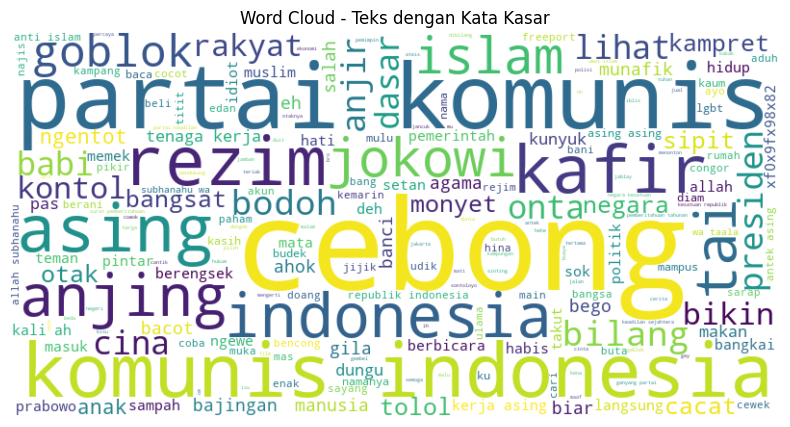

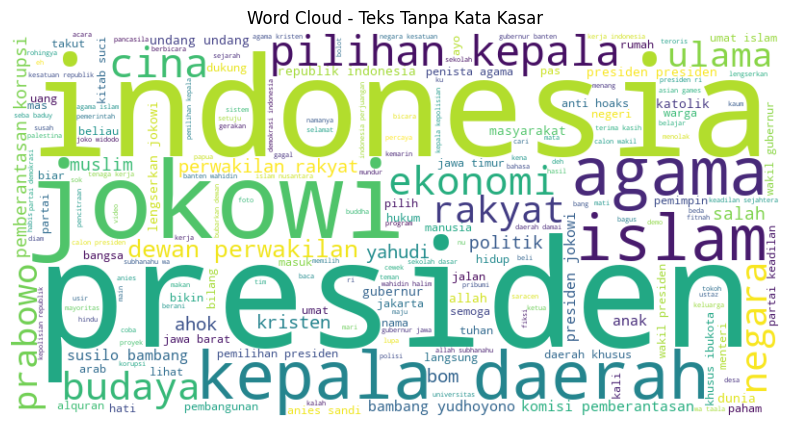

In [69]:
from wordcloud import WordCloud

# Membaca file abusive.csv
abusive = pd.read_csv('abusive.csv')

# Membuat set kata-kata kasar
abusive_words_set = set(abusive['ABUSIVE'].str.lower())

# Fungsi untuk mengecek apakah teks mengandung kata kasar
def contains_abusive(text):
    words = text.lower().split()
    return any(word in abusive_words_set for word in words)

# Menambahkan kolom 'contains_abusive' ke DataFrame sosmed
sosmed['contains_abusive'] = sosmed['remove_stopwords'].apply(contains_abusive)

# Membuat Word Cloud untuk teks yang mengandung kata kasar
text_with_abuse = ' '.join(sosmed[sosmed['contains_abusive']]['remove_stopwords'])
wordcloud_abuse = WordCloud(width=800, height=400, background_color='white').generate(text_with_abuse)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_abuse, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Teks dengan Kata Kasar')
plt.show()

# Membuat Word Cloud untuk teks yang tidak mengandung kata kasar
text_without_abuse = ' '.join(sosmed[~sosmed['contains_abusive']]['remove_stopwords'])
wordcloud_no_abuse = WordCloud(width=800, height=400, background_color='white').generate(text_without_abuse)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_no_abuse, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Teks Tanpa Kata Kasar')
plt.show()